In [1]:
import pandas as pd
import numpy as np
from __future__ import division
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
%pylab inline
pylab.rcParams['figure.figsize'] = 14, 10  # that's default image size for this interactive session

Populating the interactive namespace from numpy and matplotlib


/Users/nicholasharrigan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Import Data

In [2]:
data = pd.read_csv('pima-indians-diabetes.data', names=['preg','glucose','press','skin_thickness','insulin','bmi','pedigree','age','diabetes'])

In [4]:
data.head()

,preg,glucose,press,skin_thickness,insulin,bmi,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


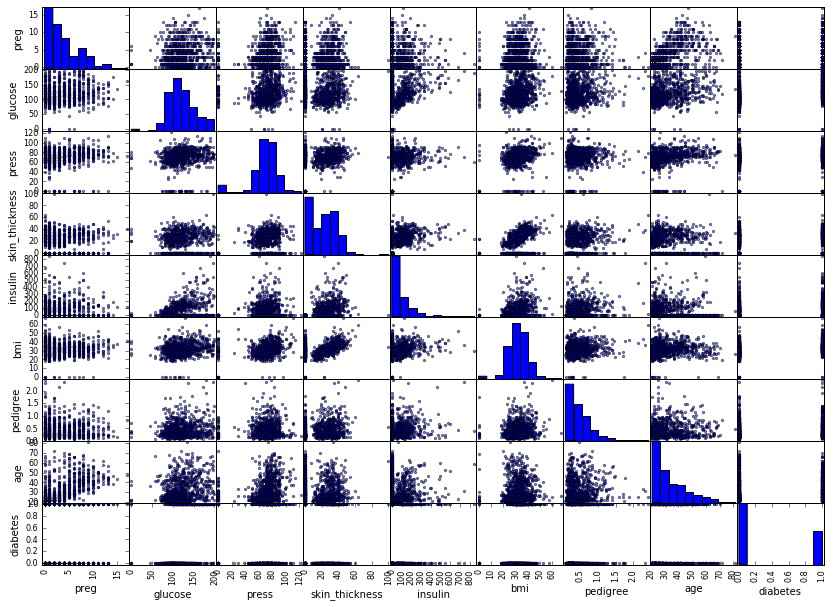

In [3]:
pd.scatter_matrix(data);

In [12]:
# Discrectize variables
# 0 -> 0-10, 1->10-20 etc...
data['skin_discrete']=pd.cut(data.skin_thickness,np.r_[0:100:11j],include_lowest=True, labels=range(10)).astype('int')
data['pedigree_discrete']=pd.cut(data.pedigree,np.r_[0:3:21j],include_lowest=True, labels=range(20)).astype('int')
data['bmi_discrete']=pd.cut(data.bmi,np.r_[0:70:11j],include_lowest=True, labels=range(10)).astype('int')
data['glucose_discrete']=pd.cut(data.glucose,np.r_[0:200:21j],include_lowest=True, labels=range(20)).astype('int')
data['press_discrete']=pd.cut(data.press,np.r_[0:150:21j],include_lowest=True, labels=range(20)).astype('int')
data['insulin_discrete']=pd.cut(data.insulin,np.r_[0:900:21j],include_lowest=True, labels=range(20)).astype('int')

### Training/test split

In [13]:
# Use sklearn to split into training and test sets
train_idx, test_idx = train_test_split(range(len(data)), test_size=0.33)
data_train = data.iloc[train_idx]
data_test = data.iloc[test_idx]
data_train.reset_index(inplace=True);
data_test.reset_index(inplace=True);

### Naive Bayes (own)

In [10]:
# Estimate prior by finding total fraction of each outcome class
N = len(data_train)
p_c1 = sum(data_train.diabetes==1)/N
p_c2 = sum(data_train.diabetes==0)/N

In [11]:
# Now form the likelihoods for each class outcome
c1 = data_train[data_train.diabetes==1]
Nc1 = len(c1)
c2 = data_train[data_train.diabetes==0]
Nc2 = len(c2)
### Likelihoods for discretized skin thickness feature
# Get unique skin category values
# skin_vals = data_train.skin_discrete.unique()
# skin_vals.sort()
skin_vals = range(0,10)
# p(skin_i|c1) and p(skin_i|c2) (as vectors over i=0..9)
post_c1_skin = {x: p_c1*sum(c1.skin_discrete==x)/Nc1 for x in skin_vals}
post_c2_skin = {x: p_c2*sum(c2.skin_discrete==x)/Nc2 for x in skin_vals}
### Likelihoods for preg feature
# preg_vals = data.preg.unique()
# preg_vals.sort()
preg_vals = range(0,21)
post_c1_preg = {x: p_c1*sum(c1.preg==x)/Nc1 for x in preg_vals}
post_c2_preg = {x: p_c2*sum(c2.preg==x)/Nc2 for x in preg_vals}
### Likelihoods for age feature
age_vals = range(18,100)
post_c1_age = {x: p_c1*sum(c1.age==x)/Nc1 for x in age_vals}
post_c2_age = {x: p_c2*sum(c2.age==x)/Nc2 for x in age_vals}

AttributeError: 'DataFrame' object has no attribute 'skin_discrete'

In [81]:
# Make predictions on test set by multiplying posterior probabilities 
# under naive bayes assumption
guess = []
for idx, row in data_test.iterrows():
    # Make prediction for this data point
    c1_guess = post_c1_skin[row.skin_discrete]*post_c1_preg[row.preg]*post_c1_age[row.age]
    c2_guess = post_c2_skin[row.skin_discrete]*post_c2_preg[row.preg]*post_c2_age[row.age]
    if c1_guess > c2_guess:
        guess.append(1)
    else:
        guess.append(0)

In [82]:
# Check fraction of results that got correct overall
100-sum([abs(x-y) for x,y in zip(guess,data_test.diabetes)])/len(data_test)*100

67.716535433070874

### Compare with sklearn naive bayes (with no laplace smoothing)

In [8]:
# Produce estimator with no laplace smoothing and estimating priors
clf = MultinomialNB(alpha=1, fit_prior=True)
X = data_train[['preg','age','skin_discrete']]
y = data_train['diabetes']
clf.fit(X,y)
sklearn_guess = clf.predict(data_test[['preg','age','skin_discrete']])
# Check how well sklearn guess does
100-sum([abs(x-y) for x,y in zip(sklearn_guess,data_test.diabetes)])/len(data_test)*100

KeyError: "['skin_discrete'] not in index"

### Sklearn Naive Bayes with more feature (nb: glucose and bmi seem correlated to diabetes) 

In [14]:
# Produce estimator with no laplace smoothing and estimating priors
features = ['preg', 'age', 'skin_discrete','bmi_discrete','glucose','press','pedigree_discrete']
# features = ['glucose','bmi']
clf = MultinomialNB(alpha=1, fit_prior=True)
X = data_train[features]
y = data_train['diabetes']
clf.fit(X,y)
sklearn_guess = clf.predict(data_test[features])
# Check how well sklearn guess does
print classification_report(sklearn_guess, data_test['diabetes'])

             precision    recall  f1-score   support

          0       0.78      0.76      0.77       176
          1       0.49      0.53      0.51        78

avg / total       0.69      0.69      0.69       254



In [15]:
# Check what score we get if randomly choose
random_guess = np.random.randint(0,2,len(data_test))
# Check how well random guess does
print classification_report(random_guess, data_test['diabetes'])

             precision    recall  f1-score   support

          0       0.50      0.73      0.59       117
          1       0.61      0.37      0.46       137

avg / total       0.56      0.54      0.52       254

